In [148]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import time

import tensorflow as tf
from tensorflow.python.keras.models import  save_model,load_model
from deepctr.layers import custom_objects

import numpy as np

Import Model
---

In [170]:
header_row = ['label','I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26']

start_load_time = time.time()
data = pd.read_csv('data/kaggle-display-advertising-challenge-dataset/train.txt', sep='\t', names=header_row, nrows=3000000)
print("Loading Time:",time.time()-start_load_time)

sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I'+str(i) for i in range(1, 14)]

data[sparse_features] = data[sparse_features].fillna('-1', )
data[dense_features] = data[dense_features].fillna(0,)
target = ['label']

 # 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])
    
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=data[feat].max() + 1, embedding_dim=4)
                          for i, feat in enumerate(sparse_features)] + [DenseFeat(feat, 1, )
                                                                        for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
    

print("Shape:",data.shape)

pd.set_option('display.max_columns', len(data))
data

Loading Time: 18.466125011444092
Shape: (3000000, 40)


,label,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
0,0,0.000827,0.000216,0.000076,0.000000,5.442957e-04,0.000017,0.000570,0.000395,0.009365,0.125,0.012903,0.000000,0.000291,604,268,848553,132728,43,7,10058,79,2,29947,3564,158090,474,4,5888,285899,9,4253,249,3,19417,0,3,57441,69,30715
1,0,0.001654,0.000162,0.000671,0.001783,4.017233e-05,0.000034,0.000076,0.000395,0.000207,0.125,0.006452,0.000000,0.000581,604,514,375982,70110,43,18,6686,23,2,7715,1540,278311,2629,17,9756,418883,0,3043,249,1,243203,0,3,19648,69,23237
2,0,0.001654,0.000162,0.000015,0.024955,3.020802e-04,0.000381,0.000152,0.000395,0.012677,0.125,0.019355,0.002333,0.006542,219,25,9426,208134,43,7,9042,23,2,10480,1858,407308,2102,2,4660,112485,6,876,0,0,575361,11,3,17088,0,0
3,0,0.000000,0.048367,0.000000,0.000000,1.729773e-03,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,604,96,572327,49409,43,18,2155,23,2,42827,4544,461549,656,2,1003,172219,1,1995,0,0,268935,0,3,41965,0,0
4,0,0.002481,0.000108,0.000000,0.000000,7.876928e-07,0.000000,0.000114,0.000000,0.000000,0.125,0.006452,0.000000,0.000000,785,381,675033,267410,43,2,7919,23,2,14642,4560,290726,2935,4,6063,3466,1,659,0,0,84436,0,2,51947,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,1,0.000827,0.048097,0.000000,0.000000,1.981047e-04,0.000150,0.000304,0.000197,0.000103,0.125,0.019355,0.000000,0.000000,527,123,435525,143822,106,7,7062,216,2,8262,3672,197215,2931,9,833,531960,0,792,0,0,326506,0,2,5344,0,0
2999996,1,0.000000,0.000108,0.000000,0.000000,1.006671e-03,0.000000,0.000761,0.000000,0.000000,0.000,0.006452,0.000000,0.000000,30,325,149572,143037,106,9,4974,23,2,4609,1873,703940,904,4,5423,225248,9,730,0,0,65868,10,8,41860,0,0
2999997,1,0.000000,0.000108,0.000000,0.000000,3.938464e-06,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,30,268,678675,119601,43,18,6818,23,0,10480,2263,492343,2715,17,2182,349245,5,3840,249,3,237220,0,11,6767,69,23797
2999998,0,0.000000,0.000486,0.000000,0.000000,1.586059e-02,0.000000,0.000000,0.004344,0.000517,0.000,0.000000,0.000000,0.000000,30,20,490018,263330,43,7,4792,397,2,10480,2093,492789,290,2,2809,389375,9,1812,0,0,10497,0,5,55990,0,0


Pre-process features for Pure Brute Force Method
---

In [194]:
trunc_data = data.copy()

sparse_features = ['C' + str(i) for i in range(1, 27)]
dense_features = ['I'+str(i) for i in range(1, 14)]

trunc_data = trunc_data.drop(columns=dense_features[5:])
trunc_data = trunc_data.drop(columns=sparse_features[1:])
trunc_data['C1'] = pd.DataFrame(np.array(['' for _ in range(len(trunc_data['C1']))]))

dense_features = ['I'+str(i) for i in range(1, 6)] #I 1-5
sparse_features = ['C' + str(i) for i in range(1, 2)]


trunc_data[sparse_features] = trunc_data[sparse_features].fillna('-1', )
trunc_data[dense_features] = trunc_data[dense_features].fillna(0,)
target = ['label']

 # 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    trunc_data[feat] = lbe.fit_transform(trunc_data[feat])
    
mms = MinMaxScaler(feature_range=(0, 1))
trunc_data[dense_features] = mms.fit_transform(trunc_data[dense_features])

# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, vocabulary_size=trunc_data[feat].max() + 1, embedding_dim=4)
                          for i, feat in enumerate(sparse_features)] + [DenseFeat(feat, 1, )
                                                                        for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
    

print("Shape:",trunc_data.shape)

pd.set_option('display.max_columns', len(trunc_data))
trunc_data

Shape: (3000000, 7)


,label,I1,I2,I3,I4,I5,C1
0,0,0.000827,0.000216,0.000076,0.000000,5.442957e-04,0
1,0,0.001654,0.000162,0.000671,0.001783,4.017233e-05,0
2,0,0.001654,0.000162,0.000015,0.024955,3.020802e-04,0
3,0,0.000000,0.048367,0.000000,0.000000,1.729773e-03,0
4,0,0.002481,0.000108,0.000000,0.000000,7.876928e-07,0
...,...,...,...,...,...,...,...
2999995,1,0.000827,0.048097,0.000000,0.000000,1.981047e-04,0
2999996,1,0.000000,0.000108,0.000000,0.000000,1.006671e-03,0
2999997,1,0.000000,0.000108,0.000000,0.000000,3.938464e-06,0
2999998,0,0.000000,0.000486,0.000000,0.000000,1.586059e-02,0


Generate the training samples and train the model
---

In [195]:
train, test = train_test_split(trunc_data, test_size=0.2)

train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=20, verbose=1, validation_split=0.2, )

Epoch 1/20
7500/7500 [==============================] - 26s 3ms/step - loss: 0.5434 - binary_crossentropy: 0.5433 - val_loss: 0.5356 - val_binary_crossentropy: 0.5356
Epoch 2/20
7500/7500 [==============================] - 22s 3ms/step - loss: 0.5338 - binary_crossentropy: 0.5338 - val_loss: 0.5347 - val_binary_crossentropy: 0.5347
Epoch 3/20
7500/7500 [==============================] - 20s 3ms/step - loss: 0.5334 - binary_crossentropy: 0.5334 - val_loss: 0.5327 - val_binary_crossentropy: 0.5327
Epoch 4/20
7500/7500 [==============================] - 29s 4ms/step - loss: 0.5328 - binary_crossentropy: 0.5328 - val_loss: 0.5361 - val_binary_crossentropy: 0.5361
Epoch 5/20
7500/7500 [==============================] - 29s 4ms/step - loss: 0.5325 - binary_crossentropy: 0.5325 - val_loss: 0.5321 - val_binary_crossentropy: 0.5321
Epoch 6/20
7500/7500 [==============================] - 44s 6ms/step - loss: 0.5326 - binary_crossentropy: 0.5326 - val_loss: 0.5317 - val_binary_crossentropy: 0.531

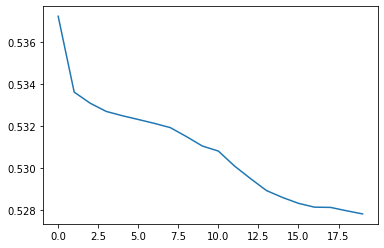

In [197]:
plt.plot(history.history['loss'])

In [198]:
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(test[target].values, pred_ans), 4))
print("test LogLoss", round(log_loss(test[target].values, pred_ans), 4))
print("test AUC", round(roc_auc_score(test[target].values, pred_ans), 4))

test MSE 0.1741
test LogLoss 0.5271
test AUC 0.6736


In [199]:
eval_result = model.evaluate(test_model_input)
print(eval_result)

18750/18750 [==============================] - 31s 2ms/step - loss: 6.3585e-07 - binary_crossentropy: 0.0000e+00
[6.358500286296476e-07, 0.0]


In [200]:
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0

for sample_i in range(len(pred_ans)):
    if round(pred_ans[sample_i][0]) == test.label.iloc[sample_i]: # Predicted == Actual
        if test.label.iloc[sample_i] == 1:
            true_pos += 1
        else:
            true_neg += 1
    else:
        if test.label.iloc[sample_i] == 1:
            false_neg += 1
        else:
            false_pos += 1

accuracy = (true_pos + true_neg) / len(pred_ans)
print("Accuracy:",accuracy)

Accuracy: 0.7519033333333334


In [201]:
save_model(model, 'DeepFMint.h5')# save_model, same as before

In [244]:
model = load_model('DeepFMint.h5',custom_objects)# load_model,just add a parameter

Initialize BFET and query rec
---

In [203]:
dense_features = ['I1','I2','I3','I4','I5']
rec_space_dim = 10
ndims = len(dense_features)
bfet_shape = (rec_space_dim,) * ndims
bfet = np.ndarray(bfet_shape)
bfet.shape

(10, 10, 10, 10, 10)

In [243]:
queryrec_feats = np.asarray([0,20,90,75,50,0])
queryrec_input = {feature_names[name]:np.asarray([queryrec_feats[name]]) for name in range(len(feature_names))}
queryrec_val = int(model.predict(queryrec_input))
print(queryrec_val)

1
